# Bank Deposit Classification

In [585]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pydotplus
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble as en
from sklearn import metrics
from numpy.random import seed
from io import StringIO
from itertools import cycle, islice
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import scale 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from IPython.display import Image  

## 1. Objective

Companies employ marketing strategies to enhance business. A subset of these strategies is telemarketing which involves using a call center to market products to customers . A Portuguese retail bank was involved in similar telemarketing endeavors to identify which customers they should contact for a deposit investment product. The dataset we obtained from the University of California at Irvine website  lists how customers were contacted and the outcome of communication. Currently, the bank calls all customers asking if they want to place a deposit. However, in the longer term, this may prove to be costly in terms of time spent on telephone. Therefore, we believe the bank would do better with a predictive model that allows them to target specific individuals as compared to taking a blanket approach.

## 2. Research Question

Given a dataset of socio-demographic, economic and call details, we would like to predict whether customers will make a deposit at the bank or not. To do so, we systematically will examine the demographic information such as age, job, marital status and its effect on deposits. Furthermore, we will examine economic indicators such as ownership of housing and loans on number of successful deposits. 

## 3. Executive Summary

We ran the below algorithms and discovered that Lasso and Logistic Regression recorded the highest sensitivity. Due to the lower cost of telephone services, in modern age, we do not consider a cost matrix in calculating misclassification costs.

#### In decreasing order of sensitivity
| Method | Sensitivity% | Specificity% | Accuracy% |
| --- | --- | --- | --- | 
| Logistic Regression | 0.99 | 0.002 | 0.89 |
| Lasso Regression | 0.99 | 0.0 | 0.88 | 
| Boosting | 0.88 | 0.081 | 0.88 |
| Classification Trees | 0.88 | 0.076 | 0.87 | 
| Bagging | 0.88 | 0.032 | 0.88 | 
| Random Forest | 0.88 | 0.003 | 0.88 |

## 4. Data Description

The dataset contains 40,000 rows and has 12 independent variables. It was obtained from https://archive.ics.uci.edu/ml/datasets/bank+marketing.
The data show how each customer was contacted by the bank to see if the former would make a deposit. The outcome would be either yes (1) or no (0).

We removed Duration from our study since in practice there would be no way of predicting how long a phone call will take. We also removed Previous from our study since a value of 0 meant an automatic non-deposit; which is counter-intuitive. The bank would want to find what other indicators are helpful for customers who have not been contacted previously.

| NAME | TYPE | VALUES |
| --- | --- | --- |
| DEPENDENT VARIABLE |
| Y -> Has client subscribed to term deposit | Categorial | Yes, No |
| INDEPENDENT VARIABLE |
| Age | Numerical |
| Job | Categorical | Categorical	Admin, Blue Collar, Entrepreneur, Housemaid, Management, Retired, Self-employed, Services, Student, Technician, Unemployed, Unknown |
| Marital Status | Categorical | Married, Single, Divorced (it includes widowed as well) |
| Education | Categorical | Yes, No |
| Credit Default | Categorical | Yes, No |
| Housing Loan | Categorical | Yes, No |
| Personal Loan | Categorical | Yes, No |
| Contact Type | Categorical | Cellular, Telephone |
| Last month of contact | Categorical |Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec |
| Last day (of the week) of contact | Categorical | Mon, Tue, Wed, Thu, Fri, Sat, Sun |
| Campaign (number of contacts performed during this campaign and for this client) | Numeric | - |

## 5. Description of data values

In [586]:
path="C:/Users/pujar/Dropbox/Semester 2/Data Mining- BUDT758T/Project/bank/"
filename="bank-full.csv"
path = path+filename
bank = pd.read_csv(path)

# Check if the data set contains any null values - Nothing found!
bank[bank.isnull().any(axis=1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
previous     0
y            0
dtype: int64

In [587]:
bank.describe()

,age,balance,day,campaign,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2.763841,0.580323
std,10.618762,3044.765829,8.322476,3.098021,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,0.000000
50%,39.000000,448.000000,16.000000,2.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,275.000000


#### Median age of customers is 39

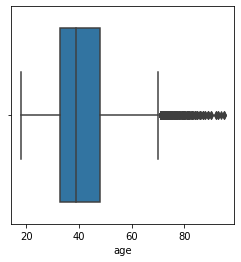

In [588]:
# Boxplot for 'age'
plt.figure(figsize=(4,4), facecolor='white')
g = sns.boxplot(x=bank["age"])

##### Most deposits were made by management and blue-collar workers. There is no clear indication of which job profile dominates here.

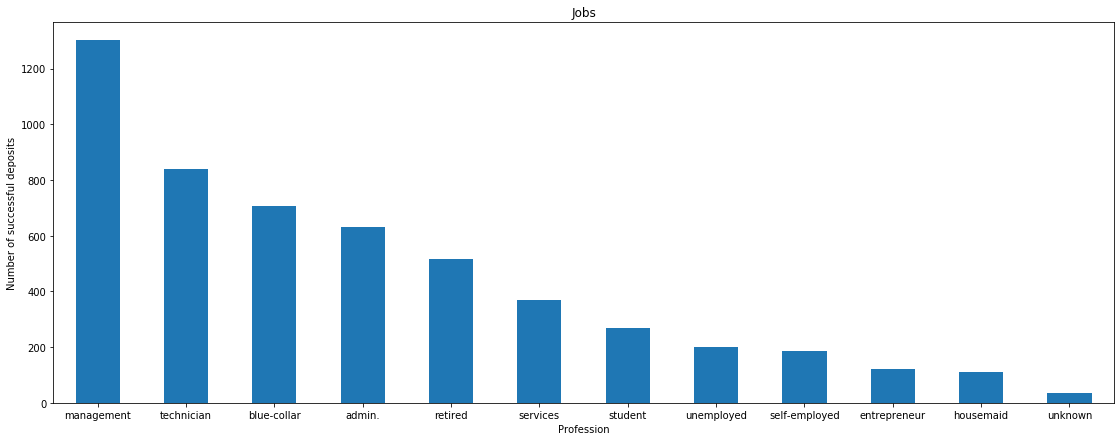

In [589]:
#Job profile of people
df = bank[bank['y']=='yes']
plt.figure(figsize=(19,7), facecolor='white')
plt.title("Jobs")
plt.ylabel('Number of successful deposits')
plt.xlabel('Profession')
df['job'].value_counts().plot.bar(x='lab', y='val', rot=0)
plt.show()

##### Married/Divorced customers were most responsive on their landline phones whereas Single customers were receptive equally well on both mobile and landline

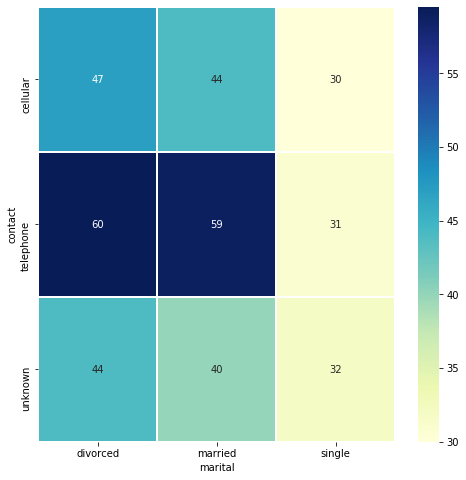

In [590]:
# Pivot table
table = df.pivot_table(index='contact', columns='marital', values='age', aggfunc='median', fill_value=0)
# Heatmap
plt.figure(figsize=(8,8), facecolor='white')
sns.heatmap(table, cmap='YlGnBu', annot=True, square=False, linewidths=1);

##### Most customers that placed deposits did not have a loan nor a house. This could be due to extra funds available for deposit.

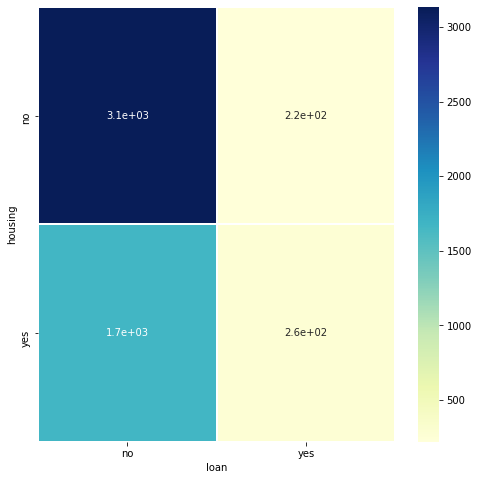

In [591]:
bank['y'] = bank['y'].str.replace('yes','1')
bank['y'] = bank['y'].str.replace('no','0')
bank['y'] = bank['y'].astype('int64')

df = bank[bank['y']==1][['housing','loan','y']]
table = df.pivot_table(index='housing', columns='loan', values='y', aggfunc='count', fill_value=0)
# Heatmap
plt.figure(figsize=(8,8), facecolor='white')
sns.heatmap(table, cmap='YlGnBu', annot=True, square=False, linewidths=1);
plt.show()

## 6. Data Manipulation

In [592]:
# Key assumption- Since the dataset does not supply the year of campaign,
# we assume that the year of campaign is 2019
bank["period"] = '2019/'+ bank["month"] + "/"+bank["day"].map(str)
bank["period"] = pd.to_datetime(bank["period"])
del bank['month']
del bank['day']
del bank['previous']

bank = bank.set_index('period', append=False)

# Explore People who made a deposit Vs Job category
jobs = ['management','blue-collar','technician','admin.','services','retired','self-employed','student',\
        'unemployed','entrepreneur','housemaid','unknown']

# Combine similar jobs into categories
bank['job'] = bank['job'].replace(['management', 'admin.'], 'white-collar')
bank['job'] = bank['job'].replace(['services','housemaid'], 'pink-collar')
bank['job'] = bank['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')
 
# Create dummy variables
bank_with_dummies = pd.get_dummies(data=bank, columns = ['job', 'marital', 'education','default','housing','loan','contact'], \
                                    prefix = ['job', 'marital', 'education','default_cat','housing_cat','loan_cat','contact_cat'])

# make a copy
bankcl = bank_with_dummies.copy()

# SOURCE: https://www.kaggle.com/shirantha/bank-marketing-data-a-decision-tree-approach

## 6.5. Split data into training, testing and validation sets

In [593]:
# Train-Test split: 20% test data
data_drop_deposite = bankcl.drop('y', 1)
label = bankcl.y
data_train, data_test, label_train, label_test = train_test_split(data_drop_deposite, label, test_size = 0.4, random_state = 1)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size = 0.4, random_state = 1)

## 7. Lasso Regression

##### According to the lasso model, Age, Balance, Job_Other, Job_WhiteCollar, Marital_Single, Education_tertiary, No Housing, No Default, No Loan and Cellular device increase the odds of customers placing a deposit. Other features decrease the odds.

In [594]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
alphas = 10**np.linspace(10,-2,100)*0.5

# check suitability for each alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(data_train), label_train)
    coefs.append(lasso.coef_)

# Best model selected by Cross Validation
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(data_train, label_train)

# Fit model according to best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(data_train, label_train)

# Display coefficients
pd.Series(lasso.coef_, index=data_test.columns)


age                      3.348941e-04
balance                  3.396631e-06
campaign                -7.278667e-03
job_blue-collar          0.000000e+00
job_entrepreneur        -1.369163e-02
job_other                8.030985e-02
job_pink-collar         -0.000000e+00
job_self-employed       -1.543954e-02
job_technician          -0.000000e+00
job_white-collar         1.358436e-02
marital_divorced         0.000000e+00
marital_married         -1.918309e-02
marital_single           1.984557e-02
education_primary       -1.424912e-02
education_secondary     -0.000000e+00
education_tertiary       1.879401e-02
education_unknown        0.000000e+00
default_cat_no           2.949340e-02
default_cat_yes         -8.723144e-17
housing_cat_no           5.197390e-02
housing_cat_yes         -0.000000e+00
loan_cat_no              4.345844e-02
loan_cat_yes            -0.000000e+00
contact_cat_cellular     2.691263e-02
contact_cat_telephone   -0.000000e+00
contact_cat_unknown     -5.748072e-02
dtype: float

In [595]:
# Predict values on test data and use a cutoff of 0.5
pred = lasso.predict(data_test)
result = np.where(pred < 0.5,0,1)

## 7.1 Confusion Matrix

In [596]:
ls_ct = pd.crosstab(np.asarray(label_test),np.asarray(result), rownames=['Actual'],colnames=['Pred'])
ls_ct

Pred,0,1
Actual,,
0,15986,1
1,2098,0


## 7.2 Performance

In [597]:
# Sensitivity
lasso_sens = (ls_ct[0][0])/(ls_ct[0][0] + ls_ct[1][0])
# Specificity
lasso_spec = (ls_ct[1][0])/(ls_ct[0][1] + ls_ct[1][0])
# Accuracy
lasso_acc = (ls_ct[0][0] + ls_ct[1][1])/(ls_ct[0][0] + ls_ct[1][0] + ls_ct[0][1] + ls_ct[1][1])

print("Sensitivity: ", lasso_sens)
print("Specificity: ", lasso_spec)
print("Accuracy: ", lasso_acc)

Sensitivity:  0.9999374491774566
Specificity:  0.0004764173415912339
Accuracy:  0.8839369643350843


## 7.3 ROC Curve

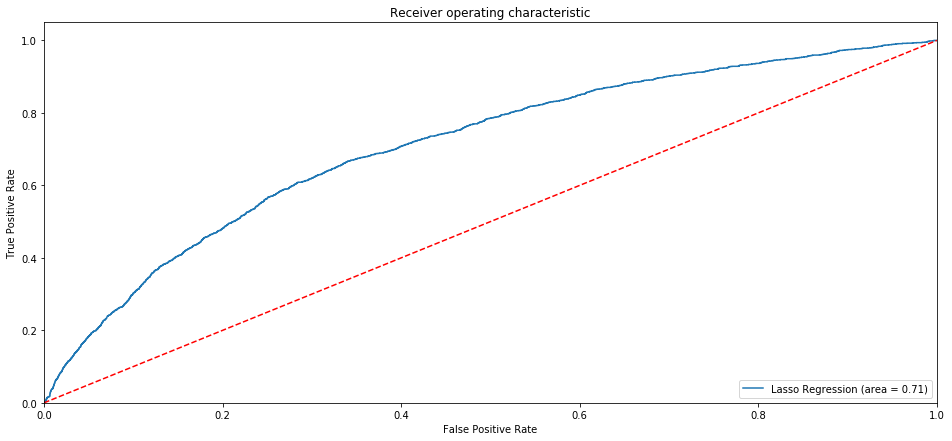

In [598]:
# Area Under Curve
lasso_roc_auc = roc_auc_score(label_test, pred)
fpr_lasso, tpr_lasso, thresholds = roc_curve(label_test, pred)

#ROC Curve
plt.figure(figsize=(16,7), facecolor='white')
plt.plot(fpr_lasso, tpr_lasso, label='Lasso Regression (area = %0.2f)' % lasso_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## 8. Logistic Regression

In [599]:
# Fit logistic model
logreg = LogisticRegression()
logreg.fit(data_train, label_train)
y_pred = logreg.predict(data_test)

C:\Users\pujar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



##### According to this model, Age and Job_other increase the odds of placing deposits. Other features decrease the odds of placing deposits. 

In [600]:
# Since the SKLearn library does not give us the below summary table, we use another library
logit_model=sm.Logit(label_train,data_train)
result=logit_model.fit()
print(result.summary2())

C:\Users\pujar\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\pujar\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in greater

C:\Users\pujar\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in less

C:\Users\pujar\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:

invalid value encountered in less_equal



Optimization terminated successfully.
         Current function value: 0.332459
         Iterations 7
                                   Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.085      
Dependent Variable:       y                      AIC:                    10861.5524 
Date:                     2019-07-22 14:20       BIC:                    11015.5001 
No. Observations:         16275                  Log-Likelihood:         -5410.8    
Df Model:                 19                     LL-Null:                -5915.7    
Df Residuals:             16255                  LLR p-value:            4.2464e-202
Converged:                1.0000                 Scale:                  1.0000     
No. Iterations:           7.0000                                                    
------------------------------------------------------------------------------------
                       Coef.    Std.Err.      z    P>|z|      [0.025       0.975]  

## 8.1 Confusion Matrix

In [601]:
log_ct = pd.crosstab(np.asarray(label_test),y_pred, rownames=['Actual'],colnames=['Pred'])
log_ct

Pred,0,1
Actual,,
0,15980,7
1,2098,0


## 8.2 Performance

In [602]:
# Sensitivity
log_sens = (log_ct[0][0])/(log_ct[0][0] + log_ct[1][0])
# Specificity
log_spec = (log_ct[1][0])/(log_ct[0][1] + log_ct[1][0])
# Accuracy
log_acc = (log_ct[0][0] + log_ct[1][1])/(log_ct[0][0] + log_ct[1][0] + log_ct[0][1] + log_ct[1][1])
print("Sensitivity: ", log_sens)
print("Specificity: ", log_spec)
print("Accuracy: ", log_acc)

Sensitivity:  0.9995621442421968
Specificity:  0.00332541567695962
Accuracy:  0.8836051976776333


## 8.3 ROC Curve

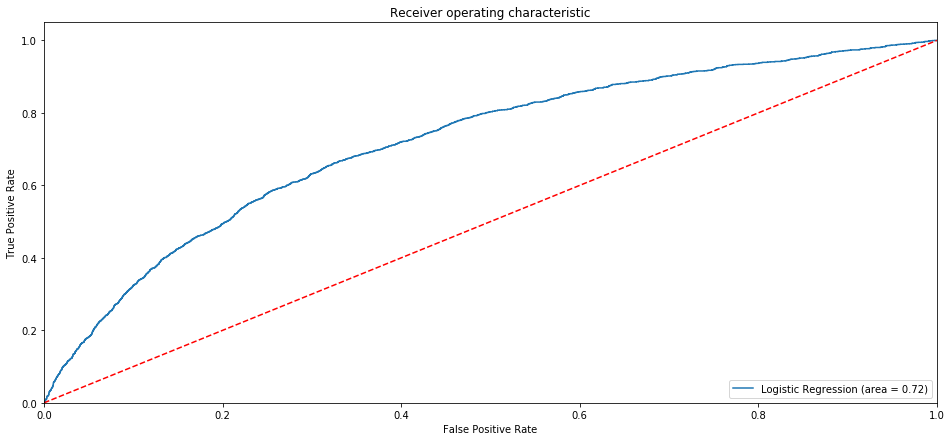

In [603]:
# Area under curve
# logit_roc_auc = roc_auc_score(label_test, y_pred)
fpr_log, tpr_log, thresholds = roc_curve(label_test, logreg.predict_proba(data_test)[:,1])
logit_roc_auc = metrics.auc(fpr_log, tpr_log)

#ROC Curve
plt.figure(figsize=(16,7), facecolor='white')
plt.plot(fpr_log, tpr_log, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 9. Classification Tree

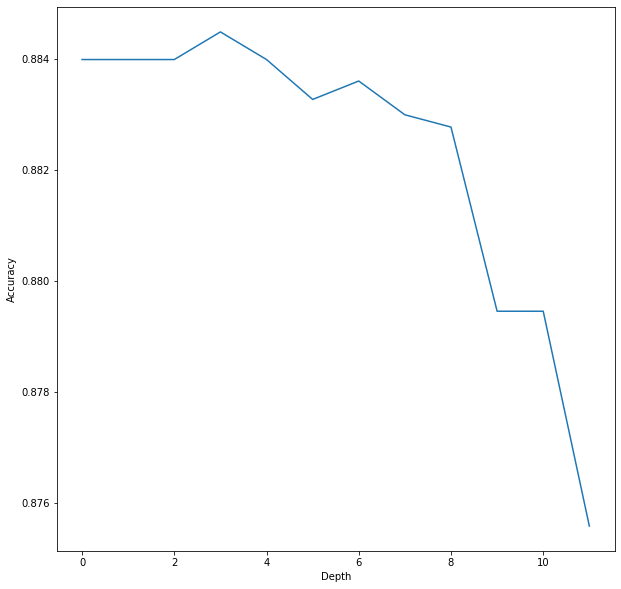

In [604]:
test_acc = []
auc = []

# For each depth (from 1 to 13) check which tree size has the highest accuracy
for i in range(1,13):
    dt2 = tree.DecisionTreeClassifier(criterion='entropy',splitter ="random",random_state=1, max_depth=i)
    dt2.fit(data_train, label_train)
    dt2_score_train = dt2.score(data_train, label_train)
    dt2_score_test = dt2.score(data_test, label_test)
    # Make predictions on the test set using predict_proba
    probs = dt2.predict_proba(data_test)[:,1]
    # Calculate the AUC metric
    auc.append(metrics.roc_auc_score(label_test, probs))
    test_acc.append(dt2_score_test)

# Plot the accuracy of each tree depth
fig, ax = plt.subplots(1, 1, sharex=False, figsize=(10, 10), facecolor='white')
ax.plot(test_acc)
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

# Sometimes we may have same accuracy for many depths- 
# hence do this to get the highest tree size to see many possible rules leading to positive classification
indices = [i for i, x in enumerate(test_acc) if x == max(test_acc)]
depth = indices[-1]

# Create a tree with the above depth
dt2 = tree.DecisionTreeClassifier(criterion='gini',splitter ="best",random_state=1, max_depth=depth)
clf = dt2.fit(data_train, label_train)
probs = dt2.predict_proba(data_val)[:,1]
result = np.where(probs < 0.5,0,1)

## 9.1 Confusion Matrix 

In [605]:
ct_tree = pd.crosstab(np.asarray(label_val),np.asarray(result), rownames=['Actual'],colnames=['Pred'])
ct_tree

Pred,0,1
Actual,,
0,9554,31
1,1248,18


## 9.2 Performance

In [606]:
# Sensitivity
tree_sens = (ct_tree[0][0]/(ct_tree[0][0] + ct_tree[0][1]))
# Specificity
tree_spec = (ct_tree[1][0])/(ct_tree[0][1] + ct_tree[1][0])
# Accuracy
tree_acc = (ct_tree[0][0] + ct_tree[1][1])/(ct_tree[0][0] + ct_tree[1][0] + ct_tree[0][1] + ct_tree[1][1])

print("Sensitivity: ", tree_sens)
print("Specificity: ", tree_spec)
print("Accuracy: ", tree_acc)

Sensitivity:  0.8844658396593224
Specificity:  0.024237685691946835
Accuracy:  0.8821306792000737


## 9.3 ROC Curve

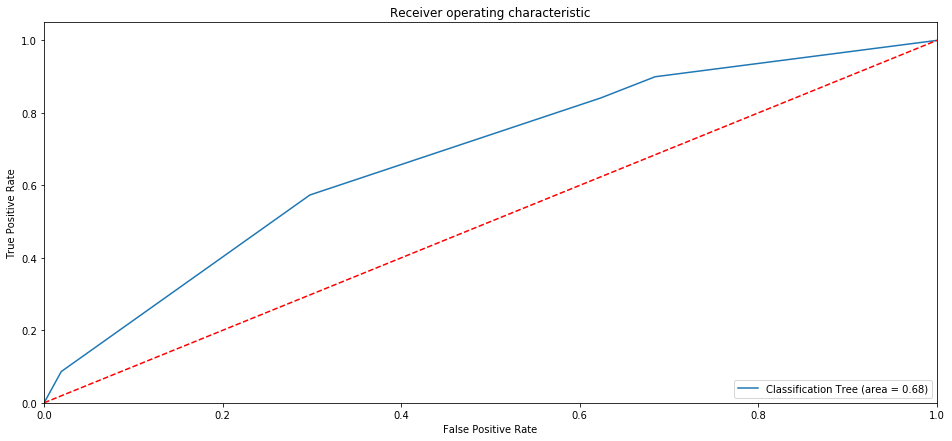

In [607]:
# Area under curve
fpr_tree, tpr_tree, thresholds = metrics.roc_curve(label_val, probs)
roc_auc = metrics.auc(fpr_tree, tpr_tree) 

# ROC Curve
plt.figure(figsize=(16,7), facecolor='white')
plt.plot(fpr_tree, tpr_tree, label='Classification Tree (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Tree_ROC')
plt.show()

## 9.4 Feature Importance

##### According to this model, the most important features are Age, Loan=Yes, Housing=No, Contact=Cellular, Job=White Collar, and Balance

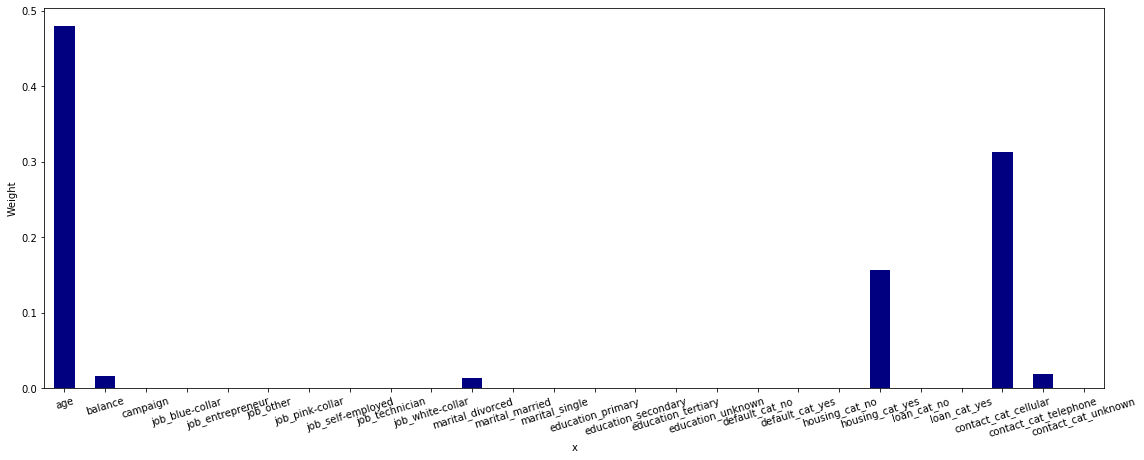

In [608]:
# Data frame - feature vs importance weights
plotdf = pd.DataFrame({'x':data_test.columns.tolist(),'y':dt2.feature_importances_.tolist()}) 
# Plot the above data frame
fig, ax = plt.subplots(1, 1, sharex=False, figsize=(19,7), facecolor='white')
plt.ylabel('Weight')
plt.xlabel('Feature')
plotdf.plot.bar(y='y', x='x', rot=17, color='#000080', ax=ax, legend=False)
plt.show()

## 9.5 Tree Rules

##### According to this model, for a successful deposit, the Age > 60.5 and  Balance <= 31313. In some cases, the customer should not be divorced.

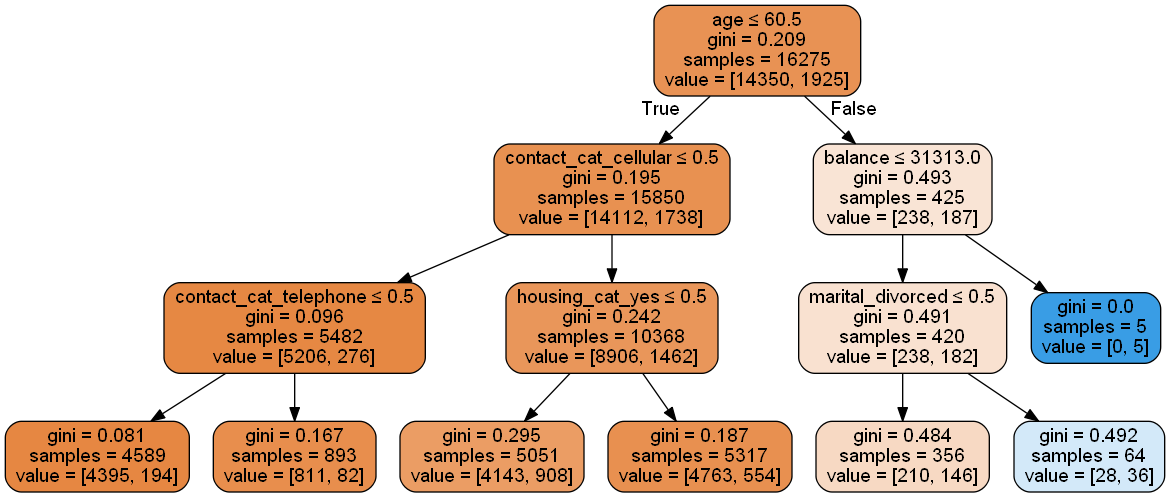

In [609]:
dot_data = StringIO()
export_graphviz(dt2, out_file=dot_data, filled=True, rounded=True,special_characters=True, feature_names = data_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassTree.png')
Image(graph.create_png())

## 10. Random Forest

In [632]:
#SOURCE: https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
dt3 = en.RandomForestClassifier(criterion='gini', max_depth=depth)
clf3 = dt3.fit(data_train, label_train)
probs3 = dt3.predict_proba(data_val)[:,1]

C:\Users\pujar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



## 10.1 Confusion Matrix

In [635]:
# Classify using a cutoff of 0.5
result = np.where(probs3 < 0.5,0,1)
rf_ct = pd.crosstab(np.asarray(label_val),np.asarray(result), rownames=['Actual'],colnames=['Pred'])
rf_ct

Pred,0,1
Actual,,
0,9580,5
1,1265,1


## 10.2 Performance

In [636]:
# Sensitivity
rf_sens = (rf_ct[0][0]/(rf_ct[0][0] + rf_ct[0][1]))
# Specificity
rf_spec = (rf_ct[1][0])/(rf_ct[0][1] + rf_ct[1][0])
# Accuracy
rf_acc = (rf_ct[0][0] + rf_ct[1][1])/(rf_ct[0][0] + rf_ct[1][0] + rf_ct[0][1] + rf_ct[1][1])
print("Sensitivity: ", rf_sens)
print("Specificity: ", rf_spec)
print("Accuracy: ", rf_acc)

Sensitivity:  0.8833563854310742
Specificity:  0.003937007874015748
Accuracy:  0.882960095843701


## 10.3 ROC Curve

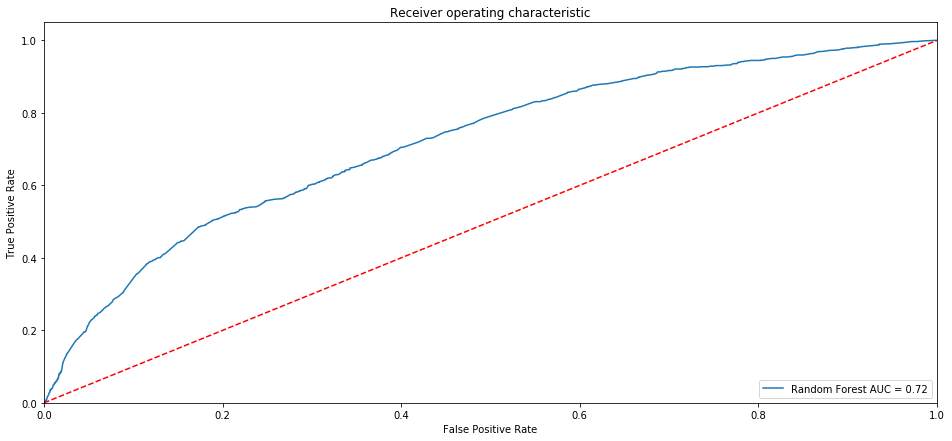

In [637]:
# Area under curve
fpr_rf, tpr_rf, thresholds3 = metrics.roc_curve(label_val, probs3)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(16,7), facecolor='white')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest AUC = %0.2f' % roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Tree_ROC')
plt.show()

## 10.4 Feature Importance

##### According to the Random Forest model, the most important features are Age, Balance,Campaign (previous contacts), Contact by Telephone, Default=Yes, Housing=No, Loan=Yes and Job=Entrepreneur

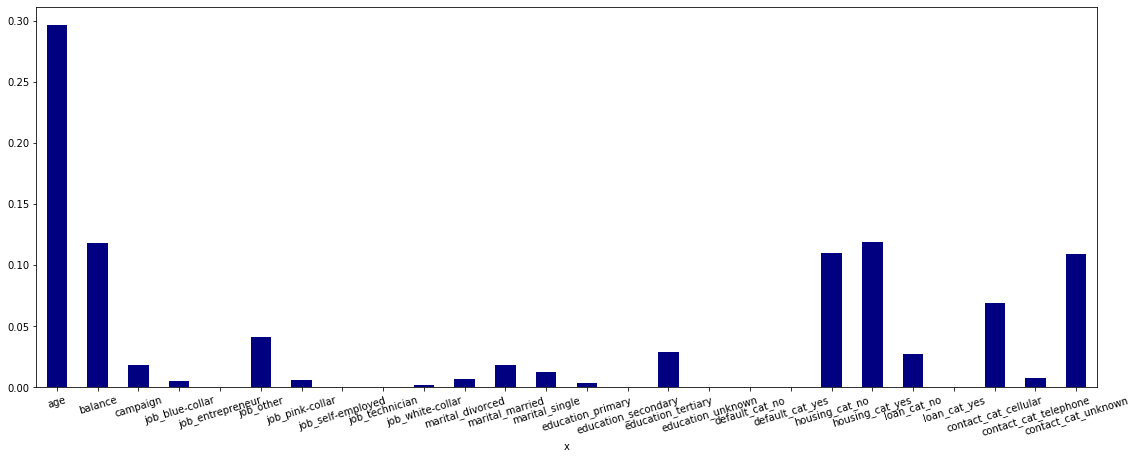

In [638]:
# Data frame containing features vs weights
plotdf = pd.DataFrame({'x':data_test.columns.tolist(),'y':dt3.feature_importances_.tolist()}) 
# Plot
fig, ax = plt.subplots(1, 1, sharex=False, figsize=(19,7), facecolor='white')
plt.title('')
plt.ylabel('')
plt.xlabel('')
plotdf.plot.bar(y='y', x='x', rot=17, color='#000080', ax=ax, legend=False)
plt.show()

## 10.5 Tree Rules

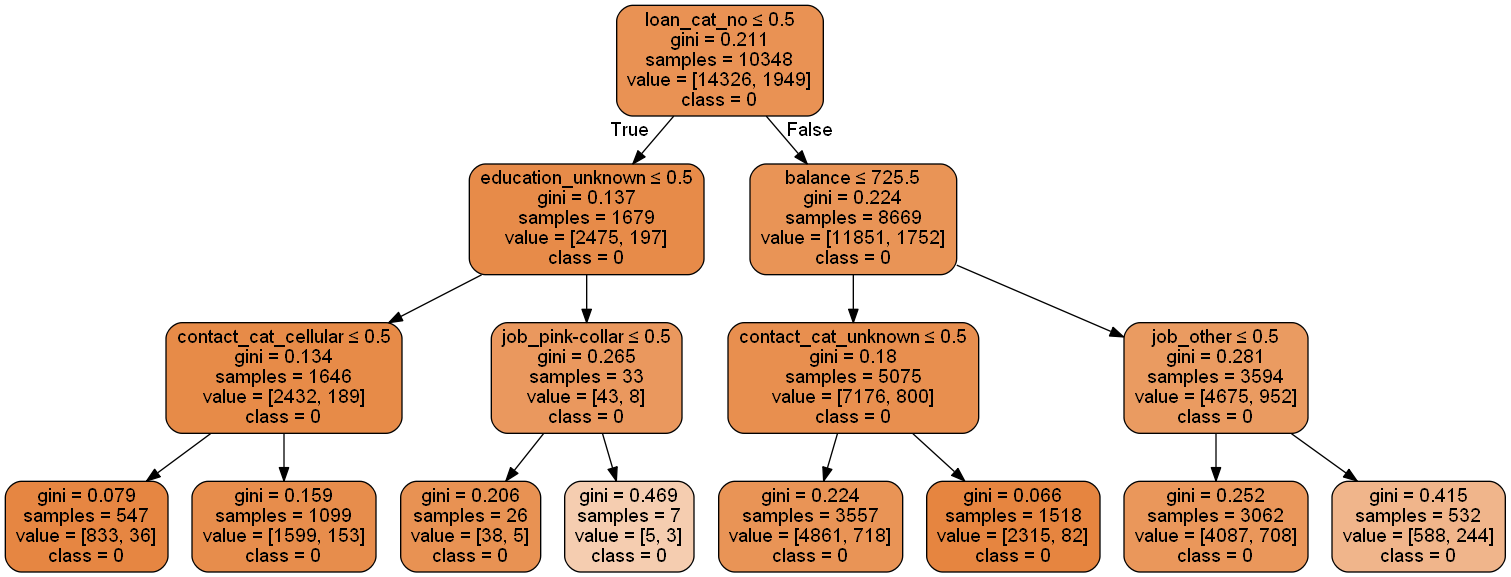

In [639]:
dot_data = StringIO()
export_graphviz(clf3.estimators_[-2], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = data_drop_deposite.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('RandomForestTree.png')
Image(graph.create_png())

##### In the above image, there are many rules that predict non-deposits. However, there are few that predict placement of a deposit. Those can be found by tracing the blue boxes to the parent node.

## 11. Bagging

In [640]:
# Bagging the classification tree model
dt4 = en.BaggingClassifier(dt2,random_state=1)
clf4 =dt4.fit(data_train, label_train)
probs4 = dt4.predict_proba(data_val)[:,1]
dt4_score_train = dt4.score(data_train, label_train)

## 11.1 Confusion Matrix

In [641]:
result = np.where(probs4 < 0.5,0,1)
bag_ct = pd.crosstab(np.asarray(label_val),np.asarray(result), rownames=['Actual'],colnames=['Pred'])
bag_ct

Pred,0,1
Actual,,
0,9554,31
1,1244,22


## 11.2 Performance

In [642]:
# Sensitivity
bag_sens = (bag_ct[0][0]/(bag_ct[0][0] + bag_ct[0][1]))
# Specificity
bag_spec = (bag_ct[1][0])/(bag_ct[0][1] + bag_ct[1][0])
# Accuracy
bag_acc = (bag_ct[0][0] + bag_ct[1][1])/(bag_ct[0][0] + bag_ct[1][0] + bag_ct[0][1] + bag_ct[1][1])
print("Sensitivity: ", bag_sens)
print("Specificity: ", bag_spec)
print("Accuracy: ", bag_acc)

Sensitivity:  0.8847934802741249
Specificity:  0.02431372549019608
Accuracy:  0.8824993088194636


## 11.3 ROC Curve

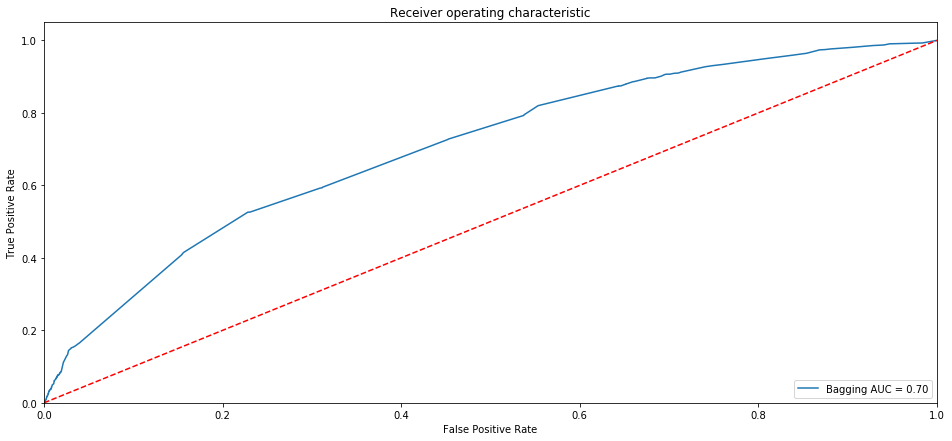

In [643]:
# Area under curve
fpr_bag, tpr_bag, thresholds4 = metrics.roc_curve(label_val, probs4)
roc_auc_bag = metrics.auc(fpr_bag, tpr_bag) 
# Plot
plt.figure(figsize=(16,7), facecolor='white')
plt.plot(fpr_bag, tpr_bag, label = 'Bagging AUC = %0.2f' % roc_auc_bag)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Tree_ROC')
plt.show()

## 11.4 Feature Importance

##### According to this model, the most important features are Age, Loan=Yes, Contact by Telephone (landline), Balance, Housing=No, Default=Yes

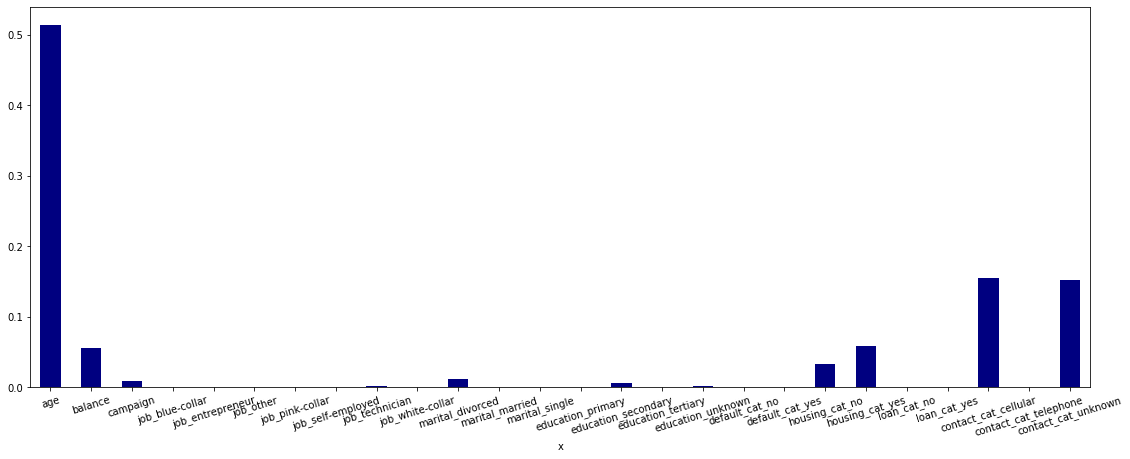

In [644]:
# Calculate mean for all bags and take an average
feature_importances = np.mean([
    tree.feature_importances_ for tree in clf4.estimators_
], axis=0)

# Data frame containing features vs weights
plotdf = pd.DataFrame({'x':data_test.columns.tolist(),'y':feature_importances.tolist()}) 

# Plot
fig, ax = plt.subplots(1, 1, sharex=False, figsize=(19,7), facecolor='white')
plt.title('')
plt.ylabel('')
plt.xlabel('')
plotdf.plot.bar(y='y', x='x', rot=17, color='#000080', ax=ax, legend=False)
plt.show()

## 12. Boosting

In [645]:
# Boost the tree model
dt5 = en.AdaBoostClassifier(random_state=1, base_estimator=dt3)
clf5 =dt5.fit(data_train, label_train)
probs5 = dt5.predict_proba(data_val)[:,1]

## 12.1 Confusion Matrix

In [646]:
result = np.where(probs5 < 0.5,0,1)
boo_ct = pd.crosstab(np.asarray(label_val),np.asarray(result), rownames=['Actual'],colnames=['Pred'])
boo_ct

Pred,0,1
Actual,,
0,9509,76
1,1208,58


## 12.2 Performance

In [647]:
# Sensitivity
boo_sens = (boo_ct[0][0]/(boo_ct[0][0] + boo_ct[0][1]))
# Specificity
boo_spec = (boo_ct[1][0])/(boo_ct[0][1] + boo_ct[1][0])
# Accuracy
boo_acc = (boo_ct[0][0] + boo_ct[1][1])/(boo_ct[0][0] + boo_ct[1][0] + boo_ct[0][1] + boo_ct[1][1])
print("Sensitivity: ", boo_sens)
print("Specificity: ", boo_spec)
print("Accuracy: ", boo_acc)

Sensitivity:  0.8872818885882243
Specificity:  0.059190031152647975
Accuracy:  0.8816698921758364


## 12.3 ROC Curve

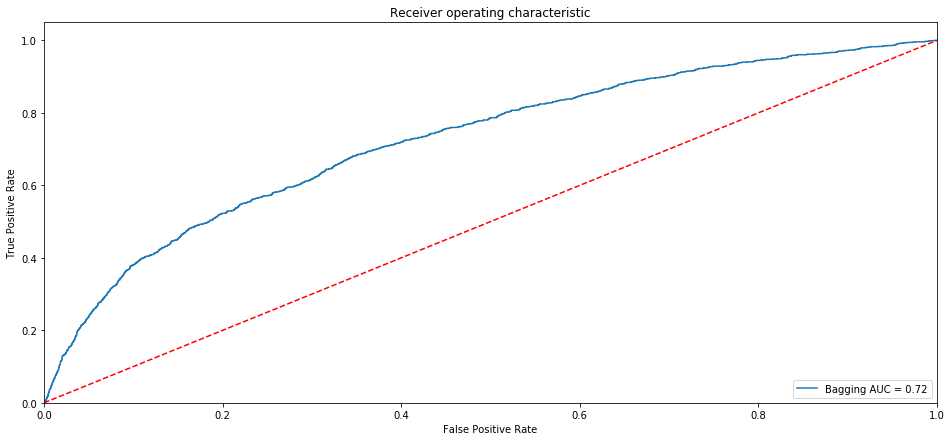

In [648]:
# Area under curve
fpr_boo, tpr_boo, thresholds5 = metrics.roc_curve(label_val, probs5)
roc_auc_boo = metrics.auc(fpr_boo, tpr_boo) 

# ROC curve
plt.figure(figsize=(16,7), facecolor='white')
plt.plot(fpr_boo, tpr_boo, label = 'Bagging AUC = %0.2f' % roc_auc_boo)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Tree_ROC')
plt.show()

## 12.4 Feature Importance

##### The most important features according to this model are Age, Balance and Campaign

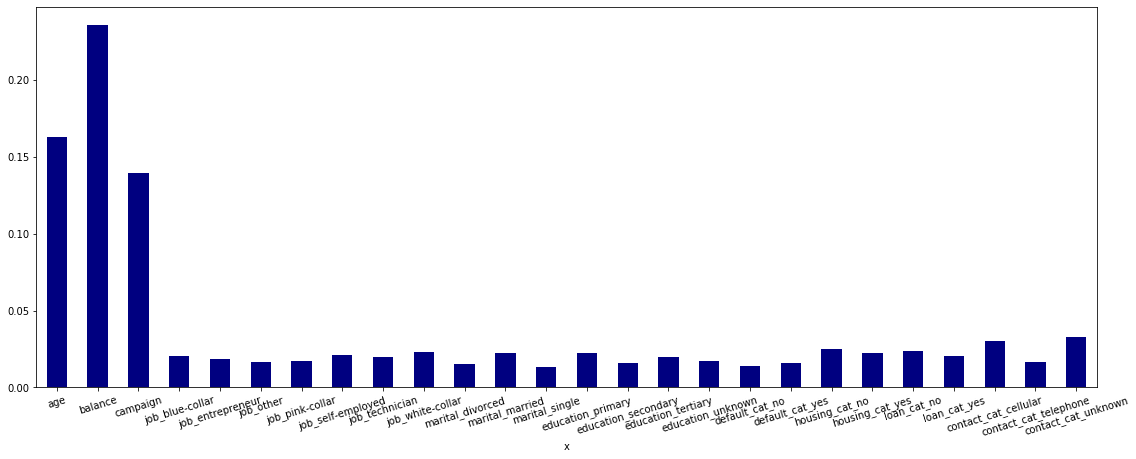

In [649]:
# Data frame containing features vs weights
plotdf = pd.DataFrame({'x':data_test.columns.tolist(),'y':dt5.feature_importances_.tolist()}) 
# Plot
fig, ax = plt.subplots(1, 1, sharex=False, figsize=(19,7), facecolor='white')
plt.title('')
plt.ylabel('')
plt.xlabel('')
plotdf.plot.bar(y='y', x='x', rot=17, color='#000080', ax=ax, legend=False)
plt.show()

## 13. Comparison of ROC Curves

##### It is clear from the below graph that Boosting has the highest Area Under Curve (AUC). Boosting will have the most clear distinction between both diagnostic groups (whether deposits will be placed or not).
##### However, we are more interested in identifying those who will place deposits, and that can be achieved by a higher sensitivity. According to #14 (below), Lasso outperforms Boosting in this respect and may prove to be more suitable to the bank's purpose of identifying those who will place deposits.

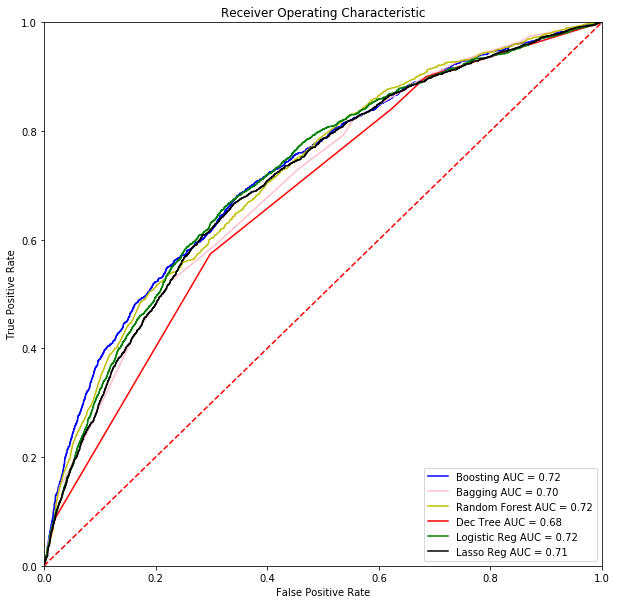

In [650]:
fig, ax = plt.subplots(1, 1, sharex=False, figsize=(10, 10), facecolor='white')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_boo, tpr_boo, 'b', label = 'Boosting AUC = %0.2f' % roc_auc_boo)
plt.plot(fpr_bag, tpr_bag, 'pink', label = 'Bagging AUC = %0.2f' % roc_auc_bag)
plt.plot(fpr_rf, tpr_rf, 'y', label = 'Random Forest AUC = %0.2f' % roc_auc_rf)
plt.plot(fpr_tree, tpr_tree, 'r', label = 'Dec Tree AUC = %0.2f' % roc_auc)
plt.plot(fpr_log, tpr_log, 'green', label = 'Logistic Reg AUC = %0.2f' %  logit_roc_auc)
plt.plot(fpr_lasso, tpr_lasso, 'black', label = 'Lasso Reg AUC = %0.2f' %  lasso_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 14. Comparing Sensitivity

##### According to the below chart, Lasso and Logistic regression have the highest sensitivity and hence are the most useful out of the algorithms employed in this study.

##### We choose sensitivity as the key metric as we are most interested in finding who will place a deposit. In the future, when the bank attempts to find who will not place a deposit to comprehend customer behaviour, we may look at specificity. 

##### Between Lasso and Logistic regression, we may look at other measures such as AUC, Specificity, Accuracy to make a decision. Both have almost the same accuracy- however, the logistic regression model has a slightly higher specificity and AUC. That could be in its favour as the chosen model.

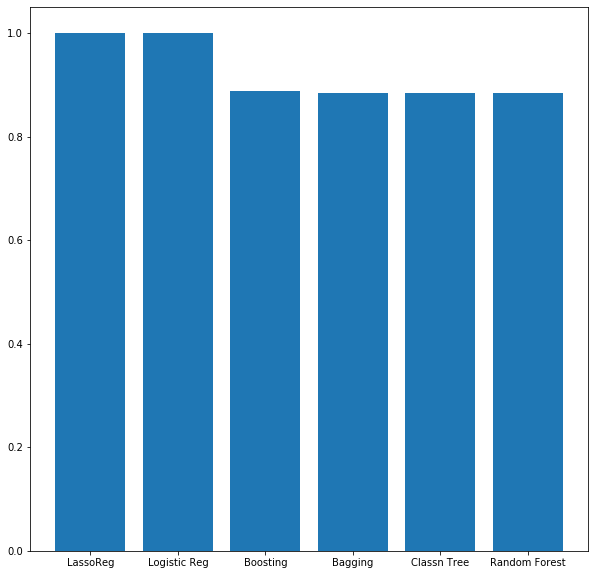

In [651]:
D = {'LassoReg':lasso_sens,'Logistic Reg':log_sens,'Classn Tree':tree_sens,'Bagging':bag_sens,'Random Forest':rf_sens,'Boosting':boo_sens}
D = dict(sorted(D.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10,10), facecolor='white')
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

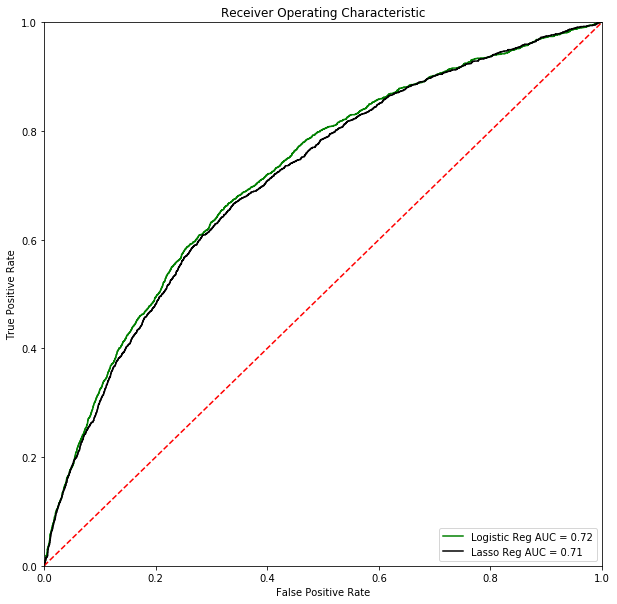

In [652]:
fig, ax = plt.subplots(1, 1, sharex=False, figsize=(10, 10), facecolor='white')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_log, tpr_log, 'green', label = 'Logistic Reg AUC = %0.2f' %  logit_roc_auc)
plt.plot(fpr_lasso, tpr_lasso, 'black', label = 'Lasso Reg AUC = %0.2f' %  lasso_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 15. Conclusion

In this day and age where cost of calling is falling down, misclassification costs to the banking industry are negligible. (https://www.lonelyplanet.com/portugal/telephone). Therefore, the bank would not lose out on much money by calling many people to convince 
them to make deposits. However, due to penalties levied upon companies in the European Union, the bank must be careful to use a filtered list (https://www.ieee-security.org/TC/SPW2018/ConPro/papers/sahin-conpro18.pdf).  
 
Furthermore, to save employee time in lieu of money (due to cheap telephone plans and the fact that 
average duration per customer reported by authors was 258 seconds), the bank must make targeted 
phone calls or take advantage of contemporary social media platforms. Since, according to our models, 
sustained communications are better for securing deposits, social media can be used to target younger 
clients. 
 
In an increasingly competitive world, the bank would do well to adopt a specialized strategy using modern 
tools than brute force their way to acquire more deposits.